# Modelling Eros with mascons

From blender we import the asteroid model, decimate it and run the following script in the python scripting window of a Windows installation of blender 2.82. 

```python 
import pickle as pk
mesh = C.selected_objects[0].data
polygons = mesh.polygons
vertices = mesh.vertices
loops = mesh.loops
points = [[v.co.x, v.co.y, v.co.z] for v in vertices]
triangles = [[loops[id].vertex_index for id in range(poly.loop_start, poly.loop_start + poly.loop_total)] for poly  in polygons] 
with open(r"C:\Users\Dario Izzo\Desktop\Eros_raw.pk", "wb") as file:
    pk.dump((points, triangles), file)
```

Its important that the above script is run in the blender python only after the asetroid has been selected.

The algorithms to deal with the 3D mesh are those containied in tetgen and pyvista. In your conda environment,
install those via pip:
```bash
pip install tetgen
```
The above line should take care of both

In [12]:
# core stuff
import pickle as pk
import numpy as np

# meshing
import pyvista as pv
import tetgen

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

#misc
import sobol_seq
from scipy import spatial

## Importing the 2D mesh
We open the file we pickled and read the mesh we exported from blender and that was normalized to have a maximum of .9 and the center of mass in the origin.

In [19]:
with open("../3dmeshes/Eros_raw.pk", "rb") as f:
    mesh_points, mesh_triangles = pk.load(f)
mesh_points = np.array(mesh_points)
mesh_triangles = np.array(mesh_triangles)
with open("../3dmeshes/Eros_raw_lp.pk", "rb") as f:
    mesh_points_lp, mesh_triangles_lp = pk.load(f)
mesh_points_lp = np.array(mesh_points_lp)
# Characteristic dimension (To know the units of the model, e.g. Eros is in km)
L = max(np.abs(mesh_points).flatten()) / 0.9
mesh_points = mesh_points / L
mesh_points_lp = mesh_points_lp / L

print("Units of lenght (Eros):", L, "Km")

Units of lenght (Eros): 19.520592159695095 Km


In [20]:
print("............................................................")
print("Number of triangles for Eros: ", len(mesh_triangles))
print("Number of points for Eros: ", len(mesh_points))
print("Physical dimension along x: ", max(mesh_points[:,0]) - min(mesh_points[:,0]), "Km")
print("............................................................")
print("Number of triangles for Eros: ", len(mesh_triangles_lp))
print("Number of points for Eros (Low Precision): ", len(mesh_points_lp))
print("Physical dimension along x (Low Precision): ", max(mesh_points_lp[:,0]) - min(mesh_points_lp[:,0]), "Km")
print("............................................................")


............................................................
Number of triangles for Eros:  14744
Number of points for Eros:  7374
Physical dimension along x:  1.6732168519475308 Km
............................................................
Number of triangles for Eros:  1474
Number of points for Eros (Low Precision):  739
Physical dimension along x (Low Precision):  1.6705021870115542 Km
............................................................


## Manipulating the mesh


In [15]:
# Non dimensional units
mesh_points = mesh_points / L * 2 * 0.8
mesh_points_lp = mesh_points_lp / L * 2 * 0.8
print("Units: ", L/2./0.8, " Km")

Units:  12.200370099809433  Km


<IPython.core.display.Javascript object>


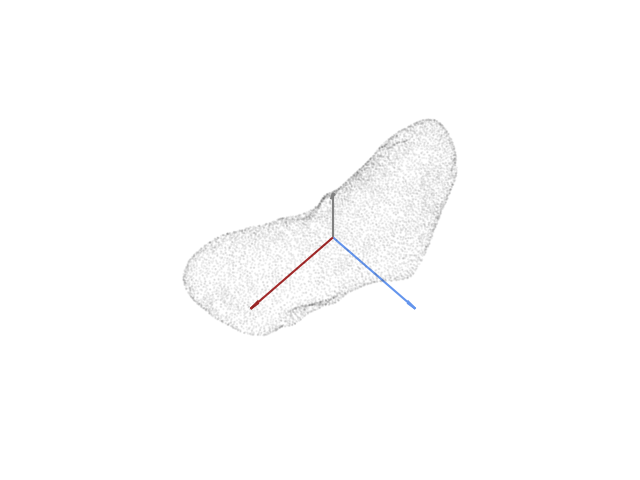

In [21]:
# Visualizing the vertices
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mesh_points[:,0], mesh_points[:,1], mesh_points[:,2], alpha=0.05, s=0.5, c='k')
ax.view_init(elev=60., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

## Generating a 3D thetraedrical grid

In [22]:
# Here we define the surface
tgen = tetgen.TetGen(mesh_points, mesh_triangles)
# Here we run the algorithm to mesh the inside with thetrahedrons
nodes, elems = tgen.tetrahedralize()

 ... and now we visualize the results

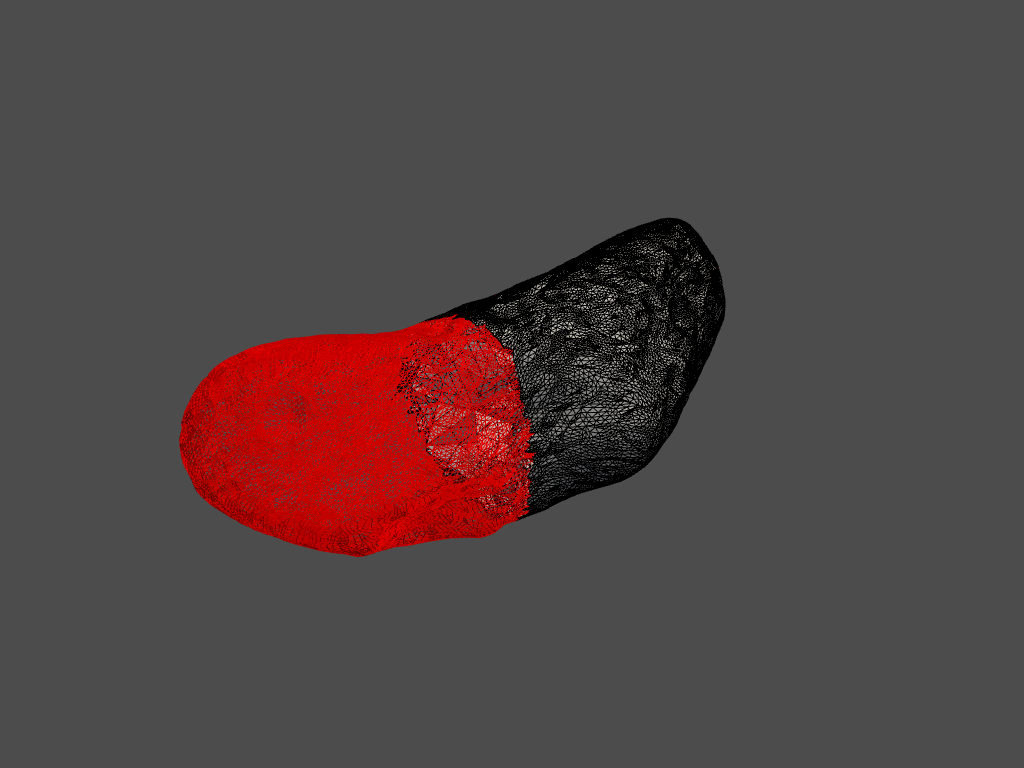

In [23]:
# get all cell centroids
grid = tgen.grid
cell_center = grid.cell_centers().points

# extract cells below the 0 xy plane
mask = cell_center[:, 0] < 0.1
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid, 'r', 'wireframe')
plotter.show()

In [24]:
grid = grid.compute_cell_sizes(volume=True, area=False, length=False)

In [25]:
mascon_points = np.array(grid.cell_centers().points)
mascon_masses = grid["Volume"]
mascon_masses = mascon_masses/sum(mascon_masses)
print("Number of resulting mascons: ", len(mascon_points))

Number of resulting mascons:  39554


<IPython.core.display.Javascript object>


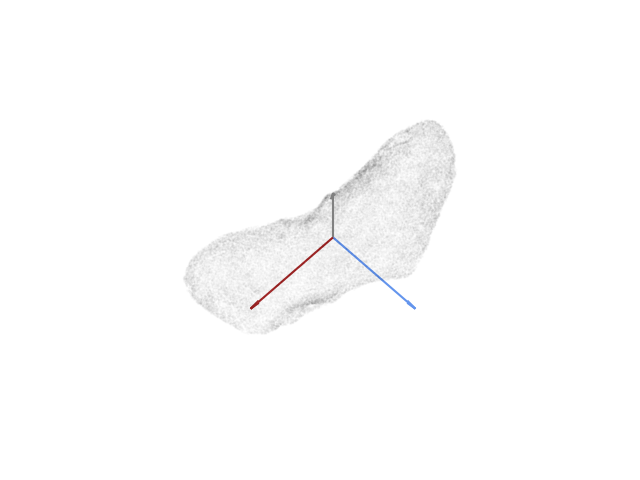

In [26]:
# Visualizing the mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.01, s=0.5, c='k')
ax.view_init(elev=60., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

## Putting the model in a frame made of principal axis of inertia

In [11]:
# COM (for meshes too)
offset = np.sum(mascon_points*mascon_masses.reshape((-1,1)), axis=0) / np.sum(mascon_masses)
mascon_points = mascon_points - offset
mesh_points = mesh_points - offset
mesh_points_lp = mesh_points_lp - offset

In [12]:
# Principal axis
I = np.matrix('0.,0.,0.;0.,0.,0.;0.,0.,0.')
I[0,0] = sum((mascon_points[:,1]*mascon_points[:,1] + mascon_points[:,2]*mascon_points[:,2]) * mascon_masses)
I[1,1] = sum((mascon_points[:,0]*mascon_points[:,0] + mascon_points[:,2]*mascon_points[:,2]) * mascon_masses)
I[2,2] = sum((mascon_points[:,0]*mascon_points[:,0] + mascon_points[:,1]*mascon_points[:,1]) * mascon_masses)
I[0,1] = -sum(mascon_points[:,0]*mascon_points[:,1]* mascon_masses)
I[1,0] = I[0,1]
I[0,2] = -sum(mascon_points[:,0]*mascon_points[:,2]* mascon_masses)
I[2,0] = I[0,2]
I[1,2] = -sum(mascon_points[:,1]*mascon_points[:,2]* mascon_masses)
I[2,1] = I[1,2]
LAM, R = np.linalg.eig(I)
R2 = np.matrix(R)
print(LAM)

[0.03573653 0.17478178 0.17779662]


In [13]:
# Rotate the mascon but also the meshes
mascon_points = np.array(mascon_points*R2)
mesh_points =  np.array(mesh_points*R2)
mesh_points_lp =  np.array(mesh_points_lp*R2)
# No need to swap axis as z is the maximum inertia axis.
mascon_points[:,0] = -mascon_points[:,0]
mascon_points[:,1] = mascon_points[:,1]
mesh_points[:,0] = -mesh_points[:,0]
mesh_points[:,1] = mesh_points[:,1]
mesh_points_lp[:,0] = -mesh_points_lp[:,0]
mesh_points_lp[:,1] = mesh_points_lp[:,1]

<IPython.core.display.Javascript object>


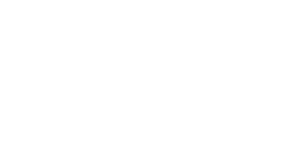

In [14]:
# Visualizing the rotated, final mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.01, s=0.5, c='k')

ax.view_init(elev=60., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

### Saving all files

In [27]:
with open("../mascons/Eros_hey.pk", "wb") as file:
    pk.dump((mascon_points, mascon_masses, "Eros"), file)
#with open("../3dmeshes/Eros.pk", "wb") as file:
#    pk.dump((mesh_points.tolist(), mesh_triangles), file)
#with open("../3dmeshes/Eros_lp.pk", "wb") as file:
#    pk.dump((mesh_points_lp.tolist(), mesh_triangles_lp), file)